<B> I'm assuming that the data is proper.

In [1]:
import os  # dealing with directories
import cv2  # working with, mainly resizing, images
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image as im
import random
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

### Uploading the images

<B> I got the uploading images idea from kaggle notebook

In [2]:
train_directory = r'/Users/idobar/Documents/GitHub/FirstFinal/train/'
train_filepath = [train_directory + last_file_name for last_file_name in os.listdir(train_directory)]
train_dogs_filepath = [train_directory + dog_file_name for dog_file_name in os.listdir(train_directory) if 'dog' in dog_file_name]
train_cats_filepath = [train_directory + cat_file_name for cat_file_name in os.listdir(train_directory) if 'cat' in cat_file_name]

In [3]:
def read_image(file_path):
    #grayscaling
    img = cv2.imread(file_path,0)
    #resizing the images to 64,64 in order to get all the images in the same size
    return cv2.resize(img, (64, 64))

In [4]:
def prep_data(images):
    image_len = len(images)
    size = 4096 #64*64
    X = np.ndarray((image_len, size), dtype=np.uint8)
    y = np.zeros((image_len, 1))
    for i, image_file in enumerate(images):
        # Sending the image to the read_image function 
        image = read_image(image_file)
        X[i, :] = np.squeeze(image.reshape((size, 1)))
        # The value will be 1 for dog and 0 for cat
        if '/dog' in image_file:
            y[i, 0] = 1
        elif '/cat' in image_file:
             y[i, 0] = 0
    return X, y

In [5]:
data,target = prep_data(train_filepath)

In [6]:
df = pd.DataFrame(data)
target=pd.DataFrame(target,columns = ['labels'])

<B> After successfully uploading the images lets do some visualization

### Visualization

In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,19,47,26,58,49,73,70,68,71,73,...,49,53,36,30,34,41,51,54,58,52
1,96,104,114,112,110,111,111,113,116,115,...,117,98,141,117,121,120,113,107,26,49
2,70,157,180,181,189,164,141,146,149,198,...,114,110,112,95,93,87,85,81,68,68
3,26,25,26,28,27,27,35,28,28,27,...,61,22,35,30,39,36,26,52,46,42
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [8]:
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
24995,24,25,28,31,25,28,24,26,40,44,...,76,72,71,75,72,71,80,76,68,78
24996,23,94,94,25,21,62,44,53,42,33,...,165,160,208,184,211,215,93,83,80,110
24997,4,3,3,2,10,6,10,16,23,22,...,170,101,128,133,98,120,118,167,82,101
24998,132,141,137,145,149,154,156,161,168,167,...,1,1,1,1,1,1,1,1,1,1
24999,87,77,76,69,64,58,55,53,60,44,...,170,134,128,189,203,154,100,100,88,52


In [9]:
df.shape

(25000, 4096)

In [10]:
target.head()

,labels
0,1.0
1,0.0
2,1.0
3,0.0
4,0.0


<AxesSubplot:ylabel='count'>

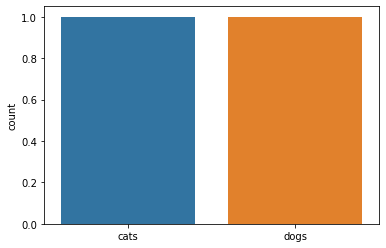

In [11]:
labels = pd.DataFrame(data=target, columns=['label'])
counts = labels.value_counts()
sns.countplot(data=counts,x=['cats','dogs'])

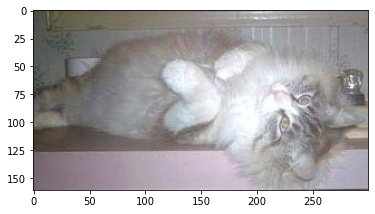

In [12]:
index= random.randint(0,24999)
im = cv2.imread(train_filepath[index])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
img = im
plt.imshow(img)

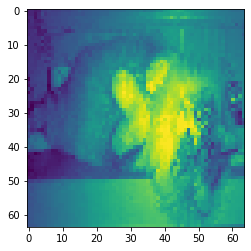

In [13]:
plt.figure()
plt.imshow(data[index].reshape(64,64))
plt.grid(False)
plt.show()

In [14]:
print("Number of missing values in the df:",df.isnull().any().sum())

Number of missing values in the df: 0


In [15]:
print("Number of missing values in the target set:",target.isnull().any().sum())

Number of missing values in the target set: 0


## Preprocessing 

In [16]:
# Adding the target dataframe to the images dataframe, just to see that the target values actually matches.
df = pd.concat([df, target], axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,labels
0,19,47,26,58,49,73,70,68,71,73,...,53,36,30,34,41,51,54,58,52,1.0
1,96,104,114,112,110,111,111,113,116,115,...,98,141,117,121,120,113,107,26,49,0.0
2,70,157,180,181,189,164,141,146,149,198,...,110,112,95,93,87,85,81,68,68,1.0
3,26,25,26,28,27,27,35,28,28,27,...,22,35,30,39,36,26,52,46,42,0.0
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0.0


In [17]:
df['labels'].value_counts()

0.0    12500
1.0    12500
Name: labels, dtype: int64

<B> We can see that the data is balanced, so now we can start training the model.
    

In [18]:
from sklearn.model_selection import train_test_split
# Droping the labels in order to get the target of the data.
train = df.drop(["labels"], axis = 1)
# Split the data to train and remaining data 
X_train,X_rem,y_train,y_rem=train_test_split(train, target, train_size=0.7, random_state=0)

In [19]:
X_valid,X_test,y_valid,y_test=train_test_split(X_rem, y_rem, test_size=0.5, random_state=0)

In [20]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(17500, 4096)
(17500, 1)
(3750, 4096)
(3750, 1)
(3750, 4096)
(3750, 1)


(None, None)

In [21]:
print("The train set as:",len(X_train),"Samples")
print("The test set as:",len(X_test),"Samples")
print("The test validation as:",len(X_valid),"Samples")

The train set as: 17500 Samples
The test set as: 3750 Samples
The test validation as: 3750 Samples


In [22]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
X_valid = X_valid.astype(np.float32)
# All the features have values between 0 to 255 so we normalize the data by dividing by 255.
X_train/=255.
X_test/=255.
X_valid/=255.

<B> Lets try some models

### KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier
k_range = list(range(1, 50))
acc = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    neigh_pred = knn.predict(X_valid)
    acc.append(metrics.accuracy_score(y_valid, neigh_pred))
acc

[0.5472,
 0.532,
 0.5597333333333333,
 0.5384,
 0.5533333333333333,
 0.5472,
 0.5664,
 0.5533333333333333,
 0.5688,
 0.5565333333333333,
 0.5685333333333333,
 0.5656,
 0.5744,
 0.5669333333333333,
 0.5826666666666667,
 0.5728,
 0.5890666666666666,
 0.5770666666666666,
 0.5936,
 0.5829333333333333,
 0.5989333333333333,
 0.5890666666666666,
 0.5944,
 0.5898666666666667,
 0.5992,
 0.5909333333333333,
 0.5946666666666667,
 0.5925333333333334,
 0.5917333333333333,
 0.5898666666666667,
 0.5933333333333334,
 0.5917333333333333,
 0.5933333333333334,
 0.5906666666666667,
 0.5962666666666666,
 0.5933333333333334,
 0.596,
 0.5949333333333333,
 0.6013333333333334,
 0.6026666666666667,
 0.6021333333333333,
 0.5997333333333333,
 0.5981333333333333,
 0.5941333333333333,
 0.5997333333333333,
 0.5968,
 0.6021333333333333,
 0.6024,
 0.6034666666666667]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.70      0.64      1863
         1.0       0.63      0.50      0.56      1887

    accuracy                           0.60      3750
   macro avg       0.61      0.60      0.60      3750
weighted avg       0.61      0.60      0.60      3750

Accuracy: 0.6034666666666667


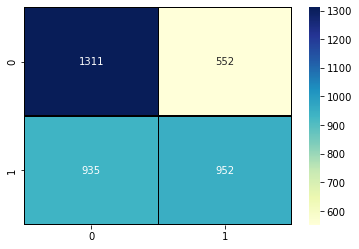

In [24]:
# We got the highest score with 49 neighbors.
confMatrix = confusion_matrix(y_valid, neigh_pred)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_valid, neigh_pred,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_valid,neigh_pred)
print("Accuracy:",result2)

### Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(X_train,y_train)
clf_pred=clf.predict(X_valid)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.54      0.56      0.55      1863
         1.0       0.55      0.53      0.54      1887

    accuracy                           0.55      3750
   macro avg       0.55      0.55      0.55      3750
weighted avg       0.55      0.55      0.55      3750

Accuracy: 0.5466666666666666


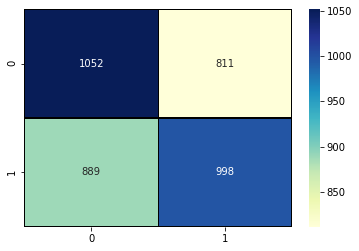

In [26]:
confMatrix = confusion_matrix(y_valid, clf_pred)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_valid, clf_pred,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_valid,clf_pred)
print("Accuracy:",result2)

### Random Forest Classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=10)
rf.fit(X_train, y_train)
rf_pred=rf.predict(X_valid)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.69      0.66      1863
         1.0       0.66      0.60      0.63      1887

    accuracy                           0.64      3750
   macro avg       0.65      0.65      0.64      3750
weighted avg       0.65      0.64      0.64      3750

Accuracy: 0.6448


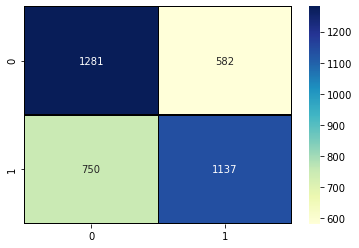

In [28]:
confMatrix = confusion_matrix(y_valid, rf_pred)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_valid, rf_pred,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_valid,rf_pred)
print("Accuracy:",result2)

### Xgboost

In [29]:
import xgboost
xgb=xgboost.XGBClassifier(n_estimators=150,eval_metric='mlogloss')
xgb.fit(X_train,y_train)
xgb_p=xgb.predict(X_valid)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.68      0.67      1863
         1.0       0.67      0.65      0.66      1887

    accuracy                           0.66      3750
   macro avg       0.66      0.66      0.66      3750
weighted avg       0.67      0.66      0.66      3750

Accuracy: 0.6648


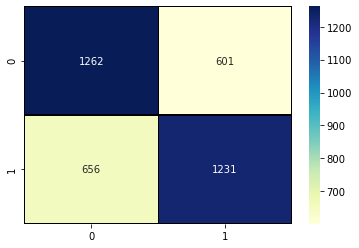

In [30]:
confMatrix = confusion_matrix(y_valid, xgb_p)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_valid, xgb_p,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_valid,xgb_p)
print("Accuracy:",result2)

### PCA

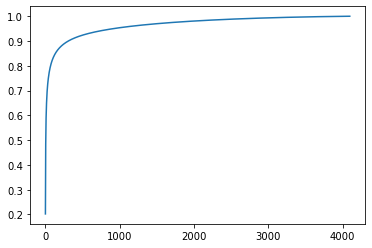

In [31]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(X_train)
sum=np.cumsum(pca.explained_variance_ratio_)
plt.plot(sum)

<B> It seems that near 1000 components we will get the best results.

In [32]:
pca=PCA(n_components=0.9)
X_trainreduce=pca.fit_transform(X_train)
X_validreduce=pca.transform(X_valid)

In [33]:
pca.n_components_

309

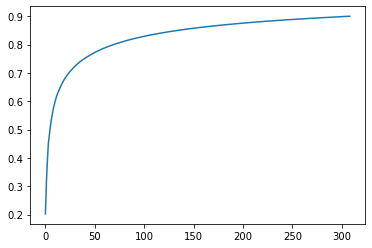

In [34]:
sum=np.cumsum(pca.explained_variance_ratio_)
plt.plot(sum)

In [35]:
X_train_pca=pd.DataFrame(X_trainreduce)
X_valid_pca=pd.DataFrame(X_validreduce)

<B> Let's try some models after the featuring reduction.

### Let's try KNN with PCA

In [36]:
acc = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_pca, y_train)
    neigh_pca_pred = knn.predict(X_valid_pca)
    acc.append(metrics.accuracy_score(y_valid, neigh_pca_pred))
acc

[0.5666666666666667,
 0.5586666666666666,
 0.5746666666666667,
 0.5746666666666667,
 0.5802666666666667,
 0.5778666666666666,
 0.5890666666666666,
 0.588,
 0.592,
 0.5850666666666666,
 0.5906666666666667,
 0.5914666666666667,
 0.5968,
 0.5962666666666666,
 0.6024,
 0.6037333333333333,
 0.6128,
 0.6098666666666667,
 0.6133333333333333,
 0.6125333333333334,
 0.6112,
 0.6154666666666667,
 0.6128,
 0.6133333333333333,
 0.6085333333333334,
 0.6149333333333333,
 0.6104,
 0.6165333333333334,
 0.6152,
 0.6186666666666667,
 0.6181333333333333,
 0.6141333333333333,
 0.6154666666666667,
 0.6162666666666666,
 0.6165333333333334,
 0.6197333333333334,
 0.6229333333333333,
 0.62,
 0.6152,
 0.6162666666666666,
 0.6144,
 0.6176,
 0.6096,
 0.6093333333333333,
 0.6106666666666667,
 0.6138666666666667,
 0.616,
 0.6165333333333334,
 0.6136]

<B> We can see that the cest score is with between 61 to 61.6

###  Logistic Regression with PCA

In [37]:
clf = LogisticRegression(random_state=0)
clf.fit(X_train_pca,y_train)
clf_pred_pca=clf.predict(X_valid_pca)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.58      0.57      1863
         1.0       0.57      0.56      0.57      1887

    accuracy                           0.57      3750
   macro avg       0.57      0.57      0.57      3750
weighted avg       0.57      0.57      0.57      3750

Accuracy: 0.5693333333333334


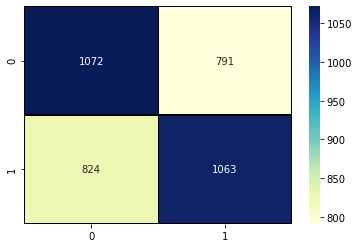

In [38]:
confMatrix = confusion_matrix(y_valid, clf_pred_pca)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_valid, clf_pred_pca,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_valid,clf_pred_pca)
print("Accuracy:",result2)

### Random Forest Classifier with PCA

In [39]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train_pca, y_train)
rf_pred_pca=rf.predict(X_valid_pca)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.65      0.62      1863
         1.0       0.62      0.58      0.60      1887

    accuracy                           0.61      3750
   macro avg       0.61      0.61      0.61      3750
weighted avg       0.61      0.61      0.61      3750

Accuracy: 0.6117333333333334


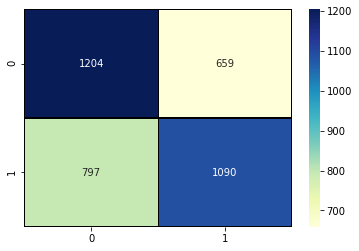

In [40]:
confMatrix = confusion_matrix(y_valid, rf_pred_pca)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_valid, rf_pred_pca,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_valid,rf_pred_pca)
print("Accuracy:",result2)

## Xgboost

In [41]:
xgb=xgboost.XGBClassifier(n_estimators=200,eval_metric='mlogloss')
xgb.fit(X_train_pca,y_train)
xgb_pca=xgb.predict(X_valid_pca)

In [42]:
metrics.accuracy_score(y_valid, xgb_pca)

0.6261333333333333

## Ensemble Learning 

<B>  Ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.

### Voting classifier

<B> Let's try voting classifier with soft voting

<B> In soft voting, every individual classifier provides a probability value that a specific data point belongs to a particular target class. The predictions are weighted by the classifier's importance and summed up. Then the target label with the greatest sum of weighted probabilities wins the vote.


In [43]:
from sklearn.ensemble import VotingClassifier
classifiers = [('Logistic Regression', clf),
               ('KNN', knn),
               ('Xgboost', xgb),             
               ('Random Forest', rf)]
for c_name, c in classifiers:
    c.fit(X_train_pca, y_train)
    preds = c.predict(X_valid_pca)
    print(f'{c_name} accuracy: {accuracy_score(y_valid, preds)*100}')

Logistic Regression accuracy: 56.93333333333334
KNN accuracy: 61.36000000000001
Xgboost accuracy: 62.61333333333333
Random Forest accuracy: 61.17333333333333


In [45]:
VC_soft = VotingClassifier(estimators=classifiers, voting='soft')
VC_soft.fit(X_train_pca, y_train)
preds = VC_soft.predict(X_valid_pca)

In [46]:
soft_vc = accuracy_score(y_valid, preds)*100
print(f'Soft Voting Classifier score: {soft_vc}')

Soft Voting Classifier score: 65.03999999999999


<B> We got the best score until now with the soft voting classifier, with only 309 components .  
    

<B> Let's try hard voting

<B> In hard voting (also known as majority voting), every individual classifier votes for a class, and the majority wins. In statistical terms, the predicted target label of the ensemble is the mode of the distribution of individually predicted labels.

In [47]:
VC_hard = VotingClassifier(estimators=classifiers, voting='hard')
VC_hard.fit(X_train_pca, y_train)
preds = VC_hard.predict(X_valid_pca)

In [48]:
hard_vc = accuracy_score(y_valid, preds)*100
print(f'Hard Voting Classifier score: {hard_vc}')

Hard Voting Classifier score: 62.98666666666667


### Stacking

<B> Stacking is an ensemble machine learning algorithm.
    It involves combining the predictions from multiple machine learning models on the same dataset, like bagging       and boosting.    
    Stacking can be described as an ensemble learning technique where the predictions of multiple classifiers           are used as new features to train a meta-classifier.  



In [50]:
from sklearn.ensemble import StackingClassifier  
estimators = [('softVC', VC_soft), ('rfc', rf), ('xgb', xgb)]
stack_clf = StackingClassifier(estimators = estimators, final_estimator = xgb)
stack_clf.fit(X_train_pca, y_train)

StackingClassifier(estimators=[('softVC',
                                VotingClassifier(estimators=[('Logistic '
                                                              'Regression',
                                                              LogisticRegression(random_state=0)),
                                                             ('KNN',
                                                              KNeighborsClassifier(n_neighbors=49)),
                                                             ('Xgboost',
                                                              XGBClassifier(base_score=0.5,
                                                                            booster='gbtree',
                                                                            colsample_bylevel=1,
                                                                            colsample_bynode=1,
                                                                            colsample_b

In [52]:
stack_clf_score = stack_clf.score(X_valid_pca, y_valid)*100  
print("Stacking Classifier Result : ",stack_clf_score)

Stacking Classifier Result :  61.626666666666665


<B> Until now i tested my model on the validation set, and it's time to test the model on the test set. 

## Test set testing  


<B> I'm only checking the best models on the test set.

In [55]:
# Create test with the pca components.
X_testreduce=pca.transform(X_test)
X_testreduce_pca=pd.DataFrame(X_testreduce)

### Random Forest 

In [56]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
rf_pred_test=rf.predict(X_test)
metrics.accuracy_score(y_test, rf_pred_test)

0.6338666666666667

### Xgboost

In [53]:
xgb=xgboost.XGBClassifier(n_estimators=200,eval_metric='mlogloss')
xgb.fit(X_train,y_train)
xgb_test=xgb.predict(X_test)
metrics.accuracy_score(y_test, xgb_test)

0.6786666666666666

### Soft voting 

In [57]:
classifiers = [('Logistic Regression', clf),
               ('KNN', knn),
               ('Xgboost', xgb),             
               ('Random Forest', rf)]
for c_name, c in classifiers:
    c.fit(X_train, y_train)
    preds = c.predict(X_test)
    print(f'{c_name} accuracy: {accuracy_score(y_test, preds)*100}')

Logistic Regression accuracy: 54.37333333333333
KNN accuracy: 60.61333333333333
Xgboost accuracy: 67.86666666666666
Random Forest accuracy: 63.38666666666667


In [58]:
VC_soft = VotingClassifier(estimators=classifiers, voting='soft')
VC_soft.fit(X_train, y_train)
preds_testsoft = VC_soft.predict(X_test)
soft_vctest = accuracy_score(y_test, preds_testsoft)
print(f'Soft Voting Classifier score: {soft_vctest}')

Soft Voting Classifier score: 0.6738666666666666


### Xgboost with pca test set 

In [64]:
xgb=xgboost.XGBClassifier(n_estimators=200,eval_metric='mlogloss')
xgb.fit(X_train_pca,y_train)
xgb_test_pca=xgb.predict(X_testreduce_pca)
metrics.accuracy_score(y_test, xgb_test_pca)

0.6368

### Voting Classifier with pca test set

In [62]:
VC_soft_pca = VotingClassifier(estimators=classifiers, voting='soft')
VC_soft_pca.fit(X_train_pca, y_train)
preds_test = VC_soft_pca.predict(X_testreduce_pca)

In [63]:
soft_vc_pca = accuracy_score(y_test, preds_test)*100
print(f'Soft Voting Classifier score: {soft_vc_pca}')

Soft Voting Classifier score: 65.52


### List of the best scores 

In [71]:
scores = [metrics.accuracy_score(y_test, xgb_test),soft_vctest,soft_vc_pca/100,accuracy_score(y_valid,rf_pred),metrics.accuracy_score(y_test, xgb_test_pca),metrics.accuracy_score(y_test, rf_pred_test)]
scores_df = pd.DataFrame(scores, index = ['Xgboost_test','SVC','SVC_PCA','Random forest','Xgboost_pca_test','Random forest'], columns = ['score'])
scores_df

,score
Xgboost_test,0.678667
SVC,0.673867
SVC_PCA,0.655200
Random forest,0.644800
Xgboost_pca_test,0.636800
Random forest,0.633867


* The scores of the test set without pca is not that better if we look at the scores of the test_pca that has only 309 components.

<B> We got the best score with the Xgboost on the test set (higher score than all of the models on the training set).